## Data science snippets
### Neural network for prediction of dynamics of Lorenz system.

The purpose of this snippet is to illustrate the data-driven approach for 
time evolution prediction of dynamic systems on the example of Lorenz system.

The Lorenz system dynamics is governed by the nonlinear system of differential equations
\begin{align}
\dfrac{\partial x}{\partial t} &= \sigma (y - x), \\
\dfrac{\partial y}{\partial t} &= x (\rho - z) - y, \\
\dfrac{\partial z}{\partial t} &= x y - \beta z,
\end{align}
where $\sigma$, $\rho$, $\beta$ are constants. 
The aim of the neural network is to learn the nonlinear mapping from state vector $\boldsymbol{s}(t_i) = [x(t_i), y(t_i), z(t_i)]$ at time moment $t_i$ to state 
$\boldsymbol{s}(t_{i+1}) = [x(t_{i+1}), y(t_{i+1}), z(t_{i+1})]$ at time moment $t_{i+1}.$

The training dataset is generated by the numberical simulation of Lorenz system.

In [67]:
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.generic_utils import get_custom_objects


In [68]:
def get_lorenz(xyz0: np.ndarray, r: float=28, s: float=10, b: float=8/3) -> np.ndarray:
    """Simation of Lorenz system for given initial conditions."""
    x0, y0, z0 = xyz0
    x = s * (y0 - x0)
    y = x0 * (r - z0) - y0
    z = x0 * y0 - b * z0
    return np.array([x, y, z])

In [69]:
n_steps = 1000
n_traject = 130
dt = 0.01

# generate random points for initial states
init_states = np.random.uniform(low=-15, high=15, size=(n_traject, 3))
# generate dataset with trajectories 
xyz = np.zeros((n_steps * n_traject, 3))
# assemble the dataset 
for j in range(n_traject):
    for i in range(n_steps-1):
        if i % (n_steps + 1) == 0:
            xyz[i + j * n_steps] = init_states[j]
            # print(i + j * n_steps)
        dot_xyz = get_lorenz(xyz[i + j * n_steps])
        xyz[i + j * n_steps + 1] = xyz[i + j * n_steps] + dt * dot_xyz

print(xyz.shape)

(130000, 3)


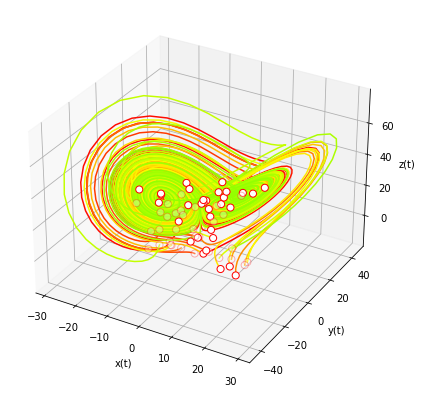

In [70]:
cmap = plt.cm.get_cmap('hsv', n_traject)
# display attractor
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection="3d")
for k in range(int(n_traject * 0.25)):
    ax.plot(xyz[n_steps * k : n_steps * k + n_steps - 1, 0], xyz[n_steps * k : n_steps * k + n_steps - 1, 1], xyz[n_steps * k : n_steps * k + n_steps - 1, 2], color=cmap(k))
    ax.scatter(xyz[[n_steps * k, n_steps * k + n_steps - 1], 0], xyz[[n_steps * k, n_steps * k + n_steps - 1], 1], xyz[[n_steps * k, n_steps * k + n_steps - 1], 2], marker='o', s=50, facecolor='w', edgecolors='r')
ax.set_xlabel("x(t)")
ax.set_ylabel("y(t)")
ax.set_zlabel("z(t)")
plt.show()

In [71]:
# assemble the training dataset
X = xyz[::2]
Y = xyz[1::2]

print(X.shape, Y.shape)


(65000, 3) (65000, 3)


In [72]:
def rbf(x):
    return keras.activations.exponential(x**2)

get_custom_objects().update({'custom_activation': layers.Activation(rbf)})

def model():
    """Deep neural network for dynamics."""
    model = keras.Sequential()
    model.add(layers.Dense(32, input_dim=X.shape[1], activation='sigmoid'))
    model.add(layers.Dense(10))
    model.add(layers.Activation(rbf, name='rbf'))
    model.add(layers.Dense(10, activation='linear'))
    model.add(layers.Dense(Y.shape[1], activation='linear'))
    # compile the keras model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    # fit the keras model on the dataset
    history = model.fit(X, Y, epochs=300, batch_size=60, validation_split=0.3)    
    return model, history


In [73]:
model, history = model()


step - loss: 0.0129 - accuracy: 0.9996 - val_loss: 0.0040 - val_accuracy: 0.9998
Epoch 164/300
759/759 [==============================] - 1s 997us/step - loss: 0.0097 - accuracy: 0.9996 - val_loss: 0.0112 - val_accuracy: 0.9997
Epoch 165/300
759/759 [==============================] - 1s 1ms/step - loss: 0.0134 - accuracy: 0.9996 - val_loss: 0.0126 - val_accuracy: 0.9992
Epoch 166/300
759/759 [==============================] - 1s 999us/step - loss: 0.0106 - accuracy: 0.9996 - val_loss: 0.0108 - val_accuracy: 0.9998
Epoch 167/300
759/759 [==============================] - 1s 1ms/step - loss: 0.0132 - accuracy: 0.9995 - val_loss: 0.0031 - val_accuracy: 0.9998
Epoch 168/300
759/759 [==============================] - 1s 1ms/step - loss: 0.0175 - accuracy: 0.9995 - val_loss: 0.0158 - val_accuracy: 0.9996
Epoch 169/300
759/759 [==============================] - 1s 1ms/step - loss: 0.0096 - accuracy: 0.9996 - val_loss: 0.0048 - val_accuracy: 0.9994
Epoch 170/300
759/759 [======================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Last epoch validation loss: 0.013647903688251972


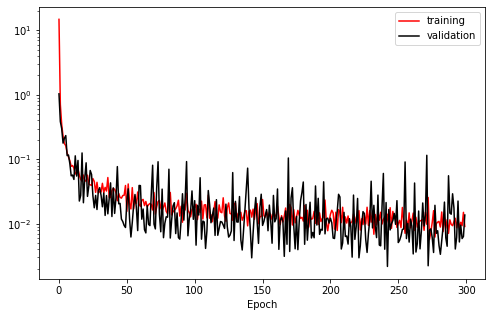

In [74]:
print(history.history.keys())
print(f"Last epoch validation loss: {history.history['val_loss'][-1]}")

fig = plt.figure(figsize = (8, 5))
ax = plt.axes()
ax.plot(history.history['loss'], color='red', label='training')
ax.plot(history.history['val_loss'], color='black', label='validation')
ax.set_yscale('log')
ax.set_xlabel('Mean Squared Error Loss')
ax.set_xlabel('Epoch')
ax.legend()
plt.show()

In [75]:
print(model.predict(np.array([X[10]])))
print(X[10], Y[10])



[[20.531488 37.53545  27.76099 ]]
[18.64461443 36.39996329 20.6533267 ] [20.42014932 37.40572257 26.88920413]


In [76]:
tvdat = np.zeros((n_steps, 3))
tvdat[0] = init_states[1]
for i in range(n_steps-1):
    tvdat[i+1] = model.predict(np.array([tvdat[i]]))

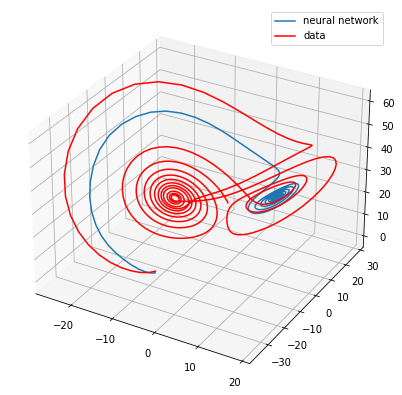

In [77]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection="3d")
ax.plot(tvdat[:,0], tvdat[:,1], tvdat[:,2], label='neural network')
ax.plot(xyz[n_steps * 1: n_steps * 1 + n_steps - 1, 0], xyz[n_steps * 1 : n_steps * 1 +n_steps - 1, 1], xyz[n_steps * 1 : n_steps * 1 +  n_steps - 1, 2], color='red', label='data')
ax.legend()
plt.show()